# Goal
Optimizing marketing campaigns is one of the most common data science tasks. Among the many possible marketing tools, one of the most efficient is using emails.
Emails are great cause they are free and can be easily personalized. Email optimization involves personalizing the text and/or the subject, who should receive it, when should be sent, etc. Machine Learning excels at this.
# Challenge Description
The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.
They have chosen a random sample of users and emailed them. The email let the user know about a new feature implemented on the site. From the marketing team perspective, a success is if the user clicks on the link inside of the email. This link takes the user to the company site.
You are in charge of figuring out how the email campaign performed and were asked the following questions:
1. What percentage of users opened the email and what percentage clicked on the link within the email?

2. The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

3. By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

4. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

# 1. Load the Data

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
email = pd.read_csv('./email_table.csv')
email_open = pd.read_csv('./email_opened_table.csv')
link = pd.read_csv('./link_clicked_table.csv')

In [3]:
email.shape, email_open.shape, link.shape

((100000, 7), (10345, 1), (2119, 1))

In [4]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [5]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [6]:
email.describe()

,email_id,hour,user_past_purchases
count,100000.000000,100000.000000,100000.00000
mean,498690.196160,9.059300,3.87845
std,289230.727534,4.439637,3.19611
min,8.000000,1.000000,0.00000
25%,246708.250000,6.000000,1.00000
50%,498447.000000,9.000000,3.00000
75%,749942.750000,12.000000,6.00000
max,999998.000000,24.000000,22.00000


In [7]:
email_open['open_email'] = np.ones(email_open.shape[0])

In [8]:
link['open_link'] = np.ones(link.shape[0])

In [9]:
email = email.merge(email_open, how='left', on='email_id')
email = email.fillna({'open_email': 0})
email = email.merge(link, how='left', on='email_id')
email = email.fillna({'open_link': 0})

In [10]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open_email,open_link
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


# 2. Explore the Data

- ### Check for Abnormal Data: those opened link but didn't open email

In [11]:
email.loc[(email['open_email']==0) & (email['open_link'] != 0)].shape[0]

50

In [12]:
drop_index = email.loc[(email['open_email']==0) & (email['open_link'] != 0)].index

In [13]:
email = email.drop(email.index[drop_index])

## 2.1 Open Rate

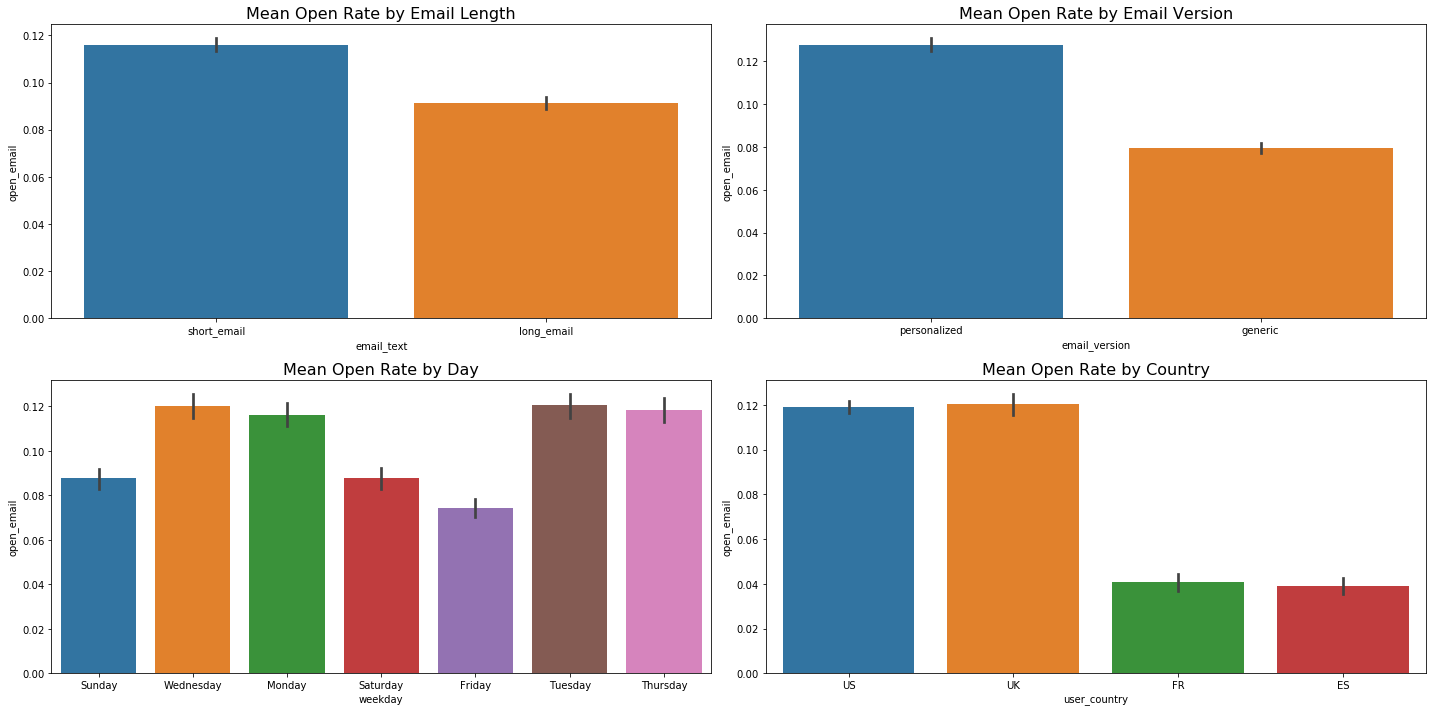

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.barplot(x='email_text', y='open_email', data=email, ax=ax[0][0])
ax[0][0].set_title('Mean Open Rate by Email Length', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='email_version', y='open_email', data=email, ax=ax[0][1])
ax[0][1].set_title('Mean Open Rate by Email Version', fontsize=16)
sns.barplot(x='weekday', y='open_email', data=email, ax=ax[1][0])
ax[1][0].set_title('Mean Open Rate by Day', fontsize=16)
sns.barplot(x='user_country', y='open_email', data=email, ax=ax[1][1])
ax[1][1].set_title('Mean Open Rate by Country', fontsize=16)
plt.tight_layout()
plt.show()

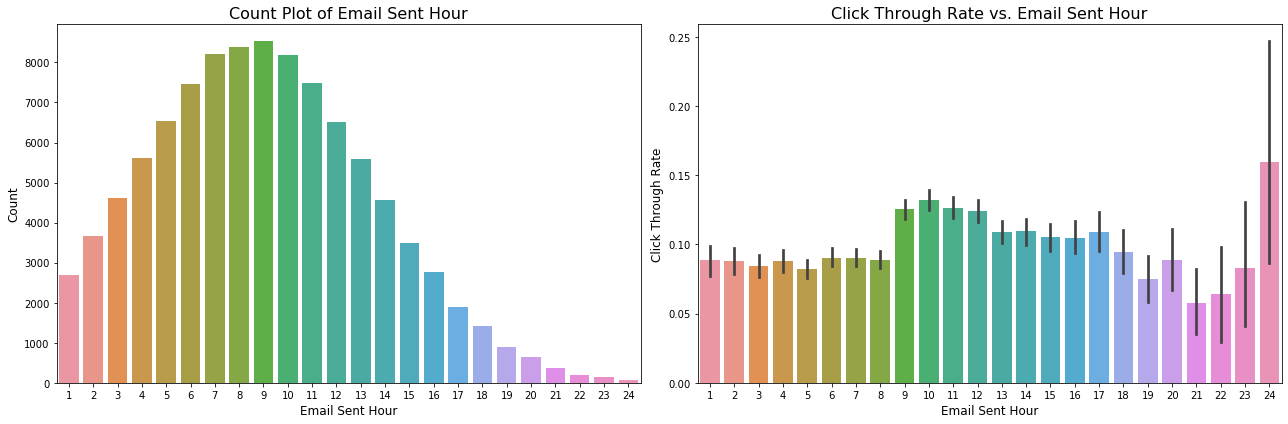

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=email, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='open_email', data=email, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

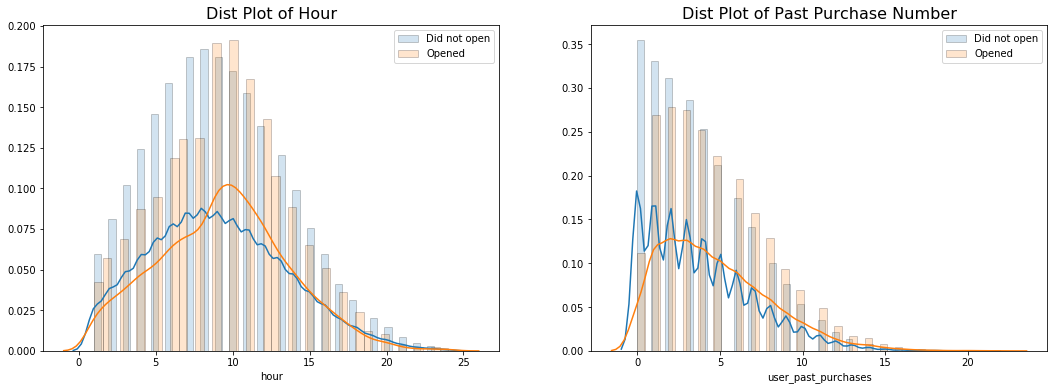

In [16]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(email[email['open_email'] == 0]['hour'], label='Did not open',
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(email[email['open_email'] == 1]['hour'], label='Opened',
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Dist Plot of Hour', fontsize=16)
ax[0].legend()
sns.distplot(email[email['open_email'] == 0]['user_past_purchases'], label='Did not open',
             ax=ax[1], hist_kws=hist_kws)
sns.distplot(email[email['open_email'] == 1]['user_past_purchases'], label='Opened',
             ax=ax[1], hist_kws=hist_kws)
ax[1].set_title('Dist Plot of Past Purchase Number', fontsize=16)
ax[1].legend()
plt.show()

## 2.2 CTR

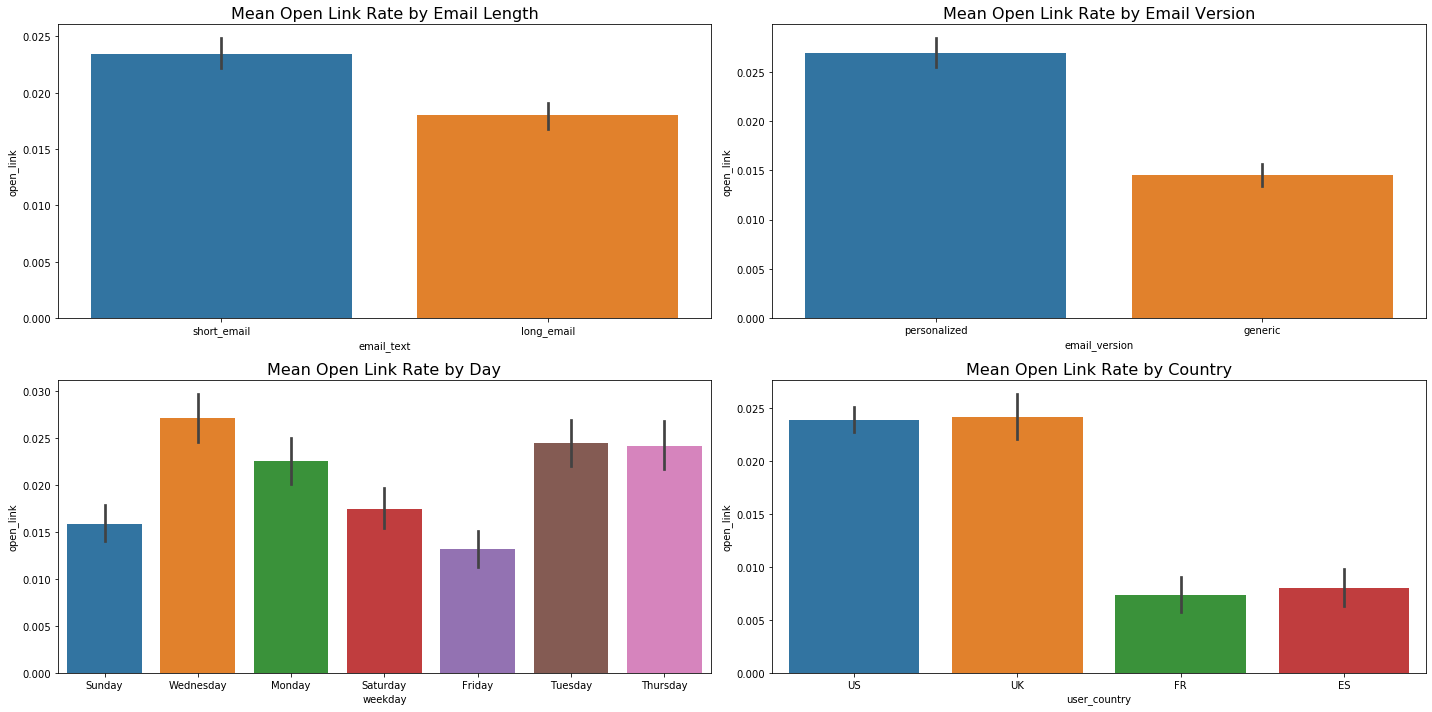

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.barplot(x='email_text', y='open_link', data=email, ax=ax[0][0])
ax[0][0].set_title('Mean Open Link Rate by Email Length', fontsize=16)
#ax[0].set_yscale('log')
sns.barplot(x='email_version', y='open_link', data=email, ax=ax[0][1])
ax[0][1].set_title('Mean Open Link Rate by Email Version', fontsize=16)
sns.barplot(x='weekday', y='open_link', data=email, ax=ax[1][0])
ax[1][0].set_title('Mean Open Link Rate by Day', fontsize=16)
sns.barplot(x='user_country', y='open_link', data=email, ax=ax[1][1])
ax[1][1].set_title('Mean Open Link Rate by Country', fontsize=16)
plt.tight_layout()
plt.show()

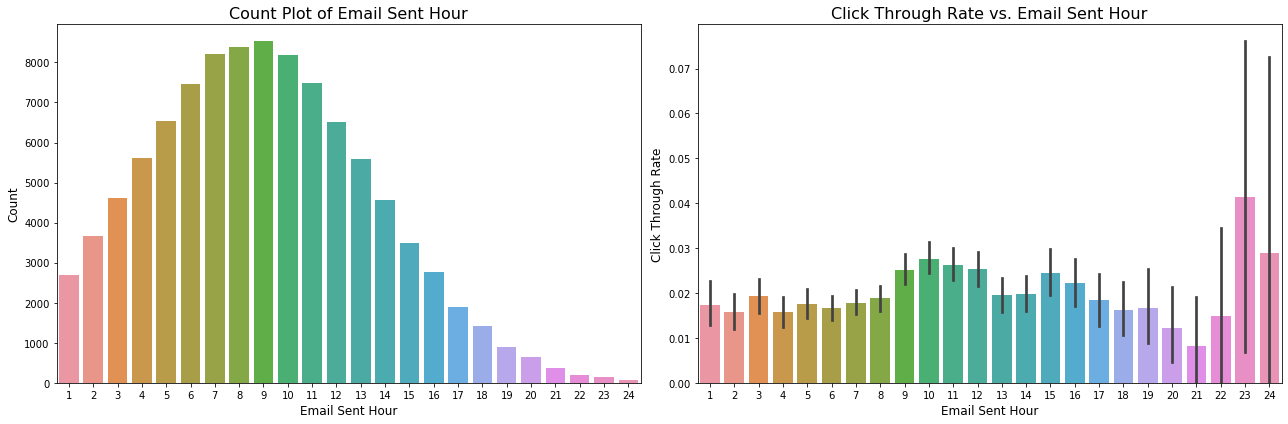

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=email, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='open_link', data=email, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

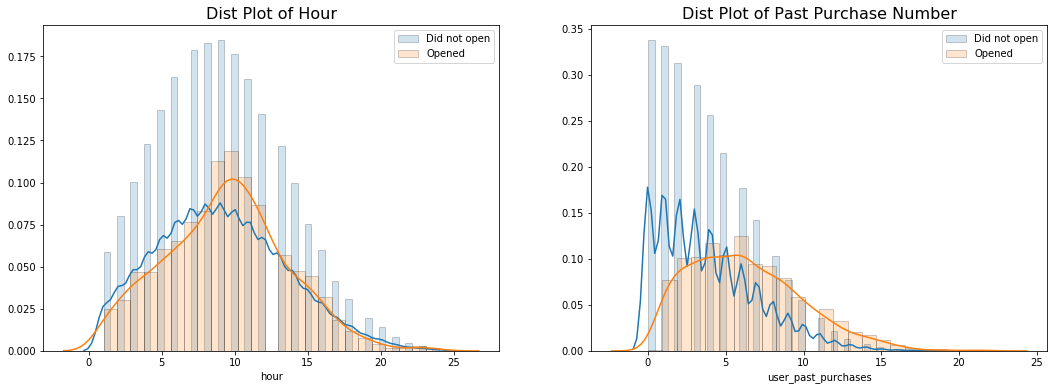

In [19]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(email[email['open_link'] == 0]['hour'], label='Did not open',
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(email[email['open_link'] == 1]['hour'], label='Opened',
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Dist Plot of Hour', fontsize=16)
ax[0].legend()
sns.distplot(email[email['open_link'] == 0]['user_past_purchases'], label='Did not open',
             ax=ax[1], hist_kws=hist_kws)
sns.distplot(email[email['open_link'] == 1]['user_past_purchases'], label='Opened',
             ax=ax[1], hist_kws=hist_kws)
ax[1].set_title('Dist Plot of Past Purchase Number', fontsize=16)
ax[1].legend()
plt.show()

## Question 1: What percentage of users opened the email and what percentage clicked on the link within the email?

In [20]:
print('percentage of users opened the email:{},\npercentage clicked on the link within the email:{},\npercentage clicked on the link within the email out of those who opened the email:{}'\
      .format(email['open_email'].mean(), email['open_link'].mean(), email.loc[email['open_email']==1]['open_link'].mean() ))

percentage of users opened the email:0.10350175087543773,
percentage clicked on the link within the email:0.020700350175087544,
percentage clicked on the link within the email out of those who opened the email:0.2


- ### In order to improve the percentage links been clicked, we could try to:
1. Improve the open rate of the email
2. Improve the open rate of the link

Based on the definition of CTR and our goal, we should directly target at the CTR without consideration of whether the email is opened or not. However, in real-life, we should consider this problem as well

# 3. Modeling

In [21]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [22]:
y = email['open_link']
#pd.get_dummies(email['open_link'])
ID = email['email_id']
X = email.drop(['open_email','open_link','email_id'],axis=1)

In [23]:
encode_text_dummy(X, 'email_text')
encode_text_dummy(X, 'email_version')
encode_text_dummy(X, 'weekday')
encode_text_dummy(X, 'user_country')

In [24]:
X = X.values

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier()

In [26]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [27]:
pred_rf = rf.predict(X_test)

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [29]:
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not Default','Default']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.977
precision is: 0.060
recall is: 0.013


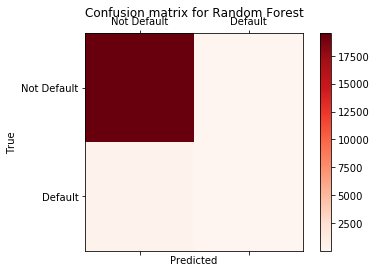

In [30]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,pred_rf)),
]
#confusion_matrices
draw_confusion_matrices(confusion_matrices)

In [31]:
rf.feature_importances_

array([0.49778713, 0.37715994, 0.00854429, 0.00800668, 0.00390747,
       0.00186881, 0.00737334, 0.01102308, 0.01018072, 0.00951435,
       0.01046916, 0.01068772, 0.0111091 , 0.00634059, 0.00596552,
       0.01183424, 0.00822787])

[05:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Final score (RMSE): 0.14058867413537612


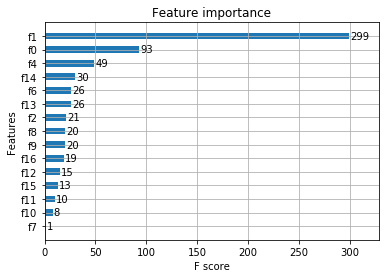

In [32]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn import metrics

GB = xgb.XGBRegressor()
GB.fit(X,y)
y_pred = GB.predict(X)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(y_pred,y))
print("Final score (RMSE): {}".format(score))
# show 20 most important features
plot_importance(GB,height=0.5,max_num_features=20)
plt.show()